# Lista 2
-------------


**Objetivo**: Treinar modelos de classificação utilizando Random Forest e XGBoost.

**Banco de Dados**: Detecção de Doenças no Fígado


[Link](https://drive.google.com/file/d/1jnLwuv4e_ZeCqluMXs3Mar2TGetumtVv/view?usp=drive_link) para o banco


Descrição do banco:
> Este banco de dados contém registros de 416 pacientes diagnosticados com doença no fígado e 167 pacientes sem a doença. Esta informação está na coluna `Selector`.
>
> Há 10 variáveis no banco:
>
> * age: idade
> * Gender: gênero do paciente
> * TB: Bilirrubina total
> * DB: Bilirrubina direta
> * Alkphos: fosfatase alcalina.
> * Sgpt: transaminase glutâmico-pirúvica sérica (TGP)
> * Sgot: transaminase glutâmico-oxalacética sérica (TGO)
> * TP: Proteína total
> * ALB: Albumina
> * A/G Ratio: Relação Albumina:Globulina


**Exercício**:
1. Carregue o banco de dados e analise suas features.

* Transforme a feature Gender em uma variável dummy.

2. Separe o banco de dados:

* Utilize 80% dos dados para treino e 20% para teste.
3. Treine um modelo de Random Forest:

* Utilize os parâmetros n_estimators=150 e max_depth=5.
* Pergunta: Quais são as duas features mais importantes?

4. Treine um modelo de XGBoost:

* Utilize os parâmetros max_depth=5, learning_rate=0.1 e n_estimators=150.
* Pergunta: Quais são as duas features mais importantes?

5. Construa um relatório comparativo dos dois modelos:

* Utilizando a **precisão da classe de pacientes doentes**, qual modelo tem melhor desempenho na detecção de doença no fígado?
* Utilizando o **f1-score da classe de pacientes doentes**, qual modelo tem melhor desempenho na detecção de doença no fígado?


Obs.: Utilize o **mesmo** conjunto de treino e teste para construir e avaliar ambos os modelos.



## 1. Carga do banco
--------------------

In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, RocCurveDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score

df = pd.read_csv('../dataset/IndianLiverPatientDataset(ILPD).csv')


Transformar a coluna Gender em dummy

In [111]:
df['Gender'] = pd.get_dummies(df['Gender'], drop_first=True)  # Female=1, Male=0

Exibir as mudanças no DataFrame

In [112]:
print(df.head())

   Age  Gender    TB   DB  Alkphos  Sgpt  Sgot   TP  ALB  A/G Ratio  Selector
0   65   False   0.7  0.1      187    16    18  6.8  3.3       0.90         1
1   62    True  10.9  5.5      699    64   100  7.5  3.2       0.74         1
2   62    True   7.3  4.1      490    60    68  7.0  3.3       0.89         1
3   58    True   1.0  0.4      182    14    20  6.8  3.4       1.00         1
4   72    True   3.9  2.0      195    27    59  7.3  2.4       0.40         1


 Verificando dados faltantes

In [113]:
df.isna().sum()

Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    4
Selector     0
dtype: int64

Preenchendo os valores faltantes com a média dos valores

In [114]:
media = df['A/G Ratio'].mean()
df['A/G Ratio'] = df['A/G Ratio'].fillna(media)

Analisando dados

In [115]:
df[['Age','TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G Ratio']].describe()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.318492
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.947064
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000


## 2. Quebra do banco
--------------------

In [116]:
# Separando os dados entre features (X) e target (y)
df['Selector'] = df['Selector'].replace({1: 1, 2: 0})

X = df.drop(columns=['Selector'])
Y = df['Selector']

# Separar o conjunto de dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)


In [117]:
df.tail()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
578,60,True,0.5,0.1,500,20,34,5.9,1.6,0.37,0
579,40,True,0.6,0.1,98,35,31,6.0,3.2,1.10,1
580,52,True,0.8,0.2,245,48,49,6.4,3.2,1.00,1
581,31,True,1.3,0.5,184,29,32,6.8,3.4,1.00,1
582,38,True,1.0,0.3,216,21,24,7.3,4.4,1.50,0


##3. Primeiro modelo
--------------------

Mdelo de Random Forest:
Utilize os parâmetros n_estimators=150 e max_depth=5.
Pergunta: Quais são as duas features mais importantes?

In [118]:
random = RandomForestClassifier(n_estimators=150,  max_depth=5)
random.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=150)

In [119]:
# Para fazer predições de classes
Y_predict = random.predict(X_test)

# Para fazer predições de probabilidade
Y_proba = random.predict_proba(X_test)


In [120]:
# Métricas de acurácia, precisão, recall, f1-score
print(classification_report(y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.42      0.15      0.22        33
           1       0.73      0.92      0.81        84

    accuracy                           0.70       117
   macro avg       0.57      0.53      0.52       117
weighted avg       0.64      0.70      0.65       117



In [121]:
# Matriz de confusão
print(confusion_matrix(y_test, Y_predict))

[[ 5 28]
 [ 7 77]]


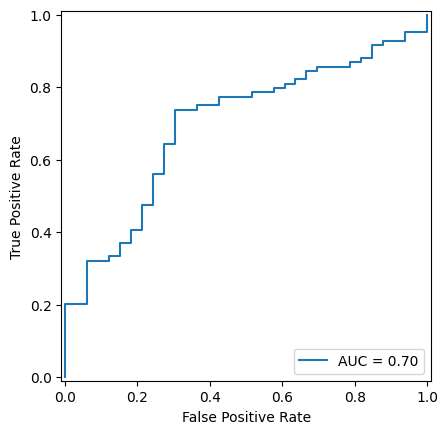

In [122]:
# AUC
roc_auc = roc_auc_score(y_test, Y_proba[:, 1])

# Specify pos_label=2 assuming 2 is the positive class in your data
fpr, tpr, thresholds = roc_curve(y_test, Y_proba[:, 1], pos_label=1)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

Duas features mais importantes

In [123]:
importances = random.feature_importances_
features_importantes = sorted(zip(importances, X.columns), reverse=True)

print("Duas features mais importantes:", features_importantes[:2])

Duas features mais importantes: [(0.16327966455068413, 'Alkphos'), (0.1461148916418847, 'TB')]


## 3.1 Interpretação de dois coeficientes
--------------------

In [124]:
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": random.feature_importances_})
print(coef_df)

# Exemplo de interpretação para coeficientes TB e ALB
print(f"Coeficiente de TB (Bilirrubina Total): {coef_df[coef_df['Feature'] == 'TB']['Coefficient'].values[0]}")
print(f"Coeficiente de Age (Idade): {coef_df[coef_df['Feature'] == 'ALB']['Coefficient'].values[0]}")

     Feature  Coefficient
0        Age     0.106190
1     Gender     0.007469
2         TB     0.146115
3         DB     0.140382
4    Alkphos     0.163280
5       Sgpt     0.107427
6       Sgot     0.141656
7         TP     0.051966
8        ALB     0.086177
9  A/G Ratio     0.049338
Coeficiente de TB (Bilirrubina Total): 0.1461148916418847
Coeficiente de Age (Idade): 0.08617714391697268


## 4. Segundo modelo
--------------------

Modelo XGBoost:
Utilize os parâmetros max_depth=5, learning_rate=0.1 e n_estimators=150.
Pergunta: Quais são as duas features mais importantes?

In [125]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)


model = XGBClassifier(objective='binary:logistic', max_depth=5,
                      verbosity=2, learning_rate=.1,
                      n_estimators=150)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)

[0]	validation_0-logloss:0.56063


[1]	validation_0-logloss:0.54657
[2]	validation_0-logloss:0.53770
[3]	validation_0-logloss:0.52685
[4]	validation_0-logloss:0.52024
[5]	validation_0-logloss:0.51487
[6]	validation_0-logloss:0.51071
[7]	validation_0-logloss:0.50728
[8]	validation_0-logloss:0.50310
[9]	validation_0-logloss:0.49797
[10]	validation_0-logloss:0.49211
[11]	validation_0-logloss:0.48847
[12]	validation_0-logloss:0.48655
[13]	validation_0-logloss:0.48775
[14]	validation_0-logloss:0.48525
[15]	validation_0-logloss:0.47932
[16]	validation_0-logloss:0.48019
[17]	validation_0-logloss:0.47889
[18]	validation_0-logloss:0.47667
[19]	validation_0-logloss:0.47662
[20]	validation_0-logloss:0.47434
[21]	validation_0-logloss:0.47365
[22]	validation_0-logloss:0.47133
[23]	validation_0-logloss:0.46634
[24]	validation_0-logloss:0.46530
[25]	validation_0-logloss:0.46500
[26]	validation_0-logloss:0.46580
[27]	validation_0-logloss:0.46151
[28]	validation_0-logloss:0.45971
[29]	validation_0-logloss:0.46124
[30]	validation_0-loglo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [126]:
predict_proba = model.predict_proba(X_test)

In [127]:
xg_pred_class = model.predict(X_test)
print(classification_report(y_test, xg_pred_class))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.95      0.98      0.96        84

    accuracy                           0.95       117
   macro avg       0.94      0.93      0.94       117
weighted avg       0.95      0.95      0.95       117



In [128]:
predict_proba = model.predict_proba(X_test)[:, 1]
acc_atual = 0
thr_otimo = 0
for thr in np.arange(0, 1, .1):
  # Replace 'Y_test' with 'y_test'
  acc = accuracy_score(y_test, predict_proba>=thr)
  if acc >= acc_atual:
    thr_otimo = thr
    acc_atual = acc

In [129]:
acc_lista = []
for thr in np.arange(0, 1, .01):
  acc_lista.append(accuracy_score(y_test, predict_proba>=thr))

px.line(x=np.arange(0, 1, .01), y=acc_lista)

## 4.1 Duas features mais importantes
--------------------

In [130]:
importances = model.feature_importances_
features_importantes = sorted(zip(importances, X.columns), reverse=True)
print("Duas features mais importantes:", features_importantes[:2])

Duas features mais importantes: [(0.23201858, 'DB'), (0.1302743, 'TB')]


## 5. Avaliação do modelo
--------------------

In [137]:


# Precisão da classe de pacientes doentes
y_pred_random = random.predict(X_test)

# Cálculo do recall dos modelos
recall_random_forest = recall_score(y_test, y_pred_random, pos_label=0)
recall_xg_boost = recall_score(y_test, xg_pred_class, pos_label=0)

# f1-score da classe de pacientes doentes
f1_random_forest = f1_score(y_test, Y_predict, pos_label=0)
f1_xg_boost = f1_score(y_test, xg_pred_class, pos_label=0)

print(f"Recall Random Forest: {recall_random_forest}")
print(f"Recall Xgboost: {recall_xg_boost}\n")

print(f"F1-score Random Forest: {f1_random_forest}")
print(f"F1-score Xgboost: {f1_xg_boost}")

Recall Random Forest: 0.15151515151515152
Recall Xgboost: 0.8787878787878788

F1-score Random Forest: 0.2222222222222222
F1-score Xgboost: 0.90625


## 5.1 Qual modelo escolhido olhando para a precisão de detecção de doença no fígado?
--------------------

In [132]:
# Comparação entre os modelos
if recall_xg_boost > recall_random_forest:
    print("O modelo XGBoost tem melhor desempenho na precisão de detecção de doença no fígado.")
else:
    print("O modelo Random Forest tem melhor desempenho na precisão de detecção de doença no fígado.")

O modelo XGBoost tem melhor desempenho na precisão de detecção de doença no fígado.


## 5.2 Qual modelo escolhido olhando para o f1-score do rótulo de doença do fígado?
--------------------

In [133]:
# Comparação entre os modelos com base no F1-score
if f1_xg_boost > f1_random_forest:
    print("O modelo XGBoost tem melhor desempenho no F1-score da detecção de doença no fígado.")
else:
    print("O modelo Random Forest tem melhor desempenho no F1-score da detecção de doença no fígado.")

O modelo XGBoost tem melhor desempenho no F1-score da detecção de doença no fígado.
